# Introduction 

I am making this package to practice my OOP skills using Python.  It is based on the work of Michael Morphew, whos Github account is here:

https://github.com/mmorphew

We are interested exploring the use of UNet (https://arxiv.org/abs/1505.04597), which is perhaps the most commonly used Deep Learning neural network architecture for semantic segmentation, for pixelwise classification of satellite images.  We hope to create a concise package for this specific task and set up a dashboard for users to experiment.  I hope to learn Plotly Dash for this activity, but we will see where we end up.  Along the way, I would also like to optimizie some hyperparameters of the model using some open-source packages and provide some simple explainations for non-ML and/or optimization experts.

Michael has obtained the data from...

In [1]:
#  Importing my first modules from my first package

from data_utils.dataset import DataLoader         #  From usatellite
from preprocessing.preprocessor import Preprocess     #  From usatellite

#  Import list
import numpy as np
import cv2
import matplotlib.pyplot as plt # for QC

## Let's get into the data

To start, we will create a data_loader object from the Dataset class.

In [2]:
loader = DataLoader()

The load_list method isn't actually loading the data, it is just setting up the paths to files on disk.  Under the
hood, we use tifffile to import the tiff files.  If you have images of another format, such as .png or.jpg, 
please feel free to investigate other packages.  It is typically straight forward to load images using Python.


In [3]:
imgs = loader.load_list('ISPRS/top', 'top_mosaic_09cm_area')

If we check out imgs, we will see that the sorting of file names is not great...  Later, this will be an issue, because the dsm data is brought in with an incompatible sorting.  The labels for objects of interest are likely out of sync as well.  

Darn!  

Let's use a built in method to fix this for now.

In [4]:
imgs = sorted(imgs)

I'm not crazy about the naming conventions for this dataset, but I'm also lazy.  This should at least work for our purposes, but please note that sorted does not seem to be an in place operation, so we need to re-assign the imgs.

Let's use list comphrehension to check out the list of images in imgs after sorting.

In [5]:
for x in imgs:
    print(x)

ISPRS/top/top_mosaic_09cm_area1.tif
ISPRS/top/top_mosaic_09cm_area10.tif
ISPRS/top/top_mosaic_09cm_area11.tif
ISPRS/top/top_mosaic_09cm_area12.tif
ISPRS/top/top_mosaic_09cm_area13.tif
ISPRS/top/top_mosaic_09cm_area14.tif
ISPRS/top/top_mosaic_09cm_area15.tif
ISPRS/top/top_mosaic_09cm_area16.tif
ISPRS/top/top_mosaic_09cm_area17.tif
ISPRS/top/top_mosaic_09cm_area2.tif
ISPRS/top/top_mosaic_09cm_area20.tif
ISPRS/top/top_mosaic_09cm_area21.tif
ISPRS/top/top_mosaic_09cm_area22.tif
ISPRS/top/top_mosaic_09cm_area23.tif
ISPRS/top/top_mosaic_09cm_area24.tif
ISPRS/top/top_mosaic_09cm_area26.tif
ISPRS/top/top_mosaic_09cm_area27.tif
ISPRS/top/top_mosaic_09cm_area28.tif
ISPRS/top/top_mosaic_09cm_area29.tif
ISPRS/top/top_mosaic_09cm_area3.tif
ISPRS/top/top_mosaic_09cm_area30.tif
ISPRS/top/top_mosaic_09cm_area31.tif
ISPRS/top/top_mosaic_09cm_area32.tif
ISPRS/top/top_mosaic_09cm_area33.tif
ISPRS/top/top_mosaic_09cm_area34.tif
ISPRS/top/top_mosaic_09cm_area35.tif
ISPRS/top/top_mosaic_09cm_area37.tif
ISPR

In [6]:
#. Need to figure this out

imgs_array = loader.load_and_resize_images(imgs, 512, 3)

We seem to have loaded the images to an array.  Let me explain this array for new comers...

The array stores a set dimensionality of data.  The first dimension describes how many images we have.  The second and third dimsions are the width and height.  For simplicity, we have set these dimensions to be equal.  The final dimension holds "channels".

I'm a geoscientist, so let me clarify this...  The definition of channel is not related to a sedimentary depositional feature, nor does it relate to earth systems!  Sorry rock jocks!  Channels simply help describe aspects of the array. In this case, channels are rgb descriptions of image color.  I prefer the rgb channels to populate the last index of an array, and I think this is the most common standard.  The first descriptor, index 0, is also considered a channel...  That is, the input channel for a machinelearning algorithm that looks at a number of examples of images.  

Let's have a look at an example below.  User is specifying just the first entry with: imgs_array[0].  This is a short-hand means of using: imgs[0:,512,512;,3].  By default, Python will interpret this to mean that all the unspecified dimensions are their max.

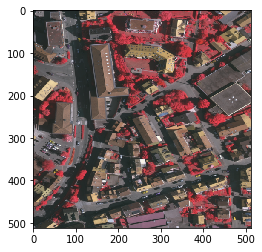

In [7]:
plt.imshow(imgs_array[0]);

Ah - looks like an aerial photograph.  I'm not used to this amount of red trees, though, so I have something to look into.  It may not really matter for our task, but it will confuse and distract clients of the tool.

OK - we loaded satellite images, but you know what?  We have other data!  Let's use load_list to tier up another set of data - digital surface (elevation) maps.  We need to apply slightly different logic to add the listed files to an array, since it has only 1 channel description.  

In [8]:
dsm_list = loader.load_list('ISPRS/dsm', 'dsm_09cm_matching_area')

In [9]:
dsm_list = sorted(dsm_list)

In [10]:
dsm_array = loader.load_and_resize_dsm(dsm_list, 512)

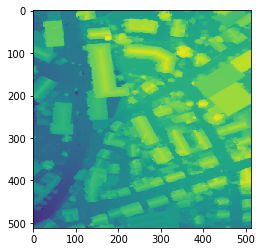

In [11]:
plt.imshow(dsm_array[0]);

Domain knowledge can be pretty useful.  Michael informed me that dsm information is important in classifying
things in satellite images.  You can probably see why in the image above...  Buildings are tall and roads are not...
At least, relatively speaking.  We probably want a classifier to be invariant to overall gradient/
topography.  Luckily, this is not Michael's first rodeo with this kind of problem, and he has suggested on means of 
adjusting via a top hat filter.  Let's apply the filter (with a kernel size I dialied in for now) to have a look.

### ML NOTE

By the way, what proceeds is feature engineering.  That is, we are deterministically engineering features that will 
help statistical algorithms classify pixels in images.  Convolutional neural networks, given enough relevant images
should be able to engineer features on their own - that is one of the big innovations with them. In my experience, they often engineer features that are more relevant than what we provide, so I typically avoid this.  However, we have few examples, so it will depend on our data augmentation tactics.  We can evaluate via metrics later.

In [12]:
preproc = Preprocess()

In [13]:
dsm_tophat = preproc.top_hat_filter(dsm_array, 75)

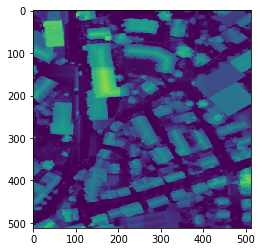

In [14]:
plt.imshow(dsm_tophat[0])

Not that bad if I say so myself.  These images are pretty simple compared to what we'd expect in the wild, but it is
still encouraging that these open-source tricks can get us this far.  You should consider, though, that the image extraction itself relies on a kernel size.  What about when we want to perform inference?  Are we striding over larger images, or collection patchs for predictions?  There are a number of potential solutions, but we do not address that here.  

In our case, images are of different size and we resize them to something common (512x512).  What the heck does this imply, though?  It's basically changing the true aspect ratio of the images!  Mind if someone squishes your neighborhood?  That's basically what we did.  It may not be an issue for the neural network.  In fact, this could be a nice data augmentation to help generalization...  But you, as a developer, should consider the implications and work with them.  

Ok - with that out of the way...  Let's visualize an image with the corresponding dsm (with inferno because I like the colormap).

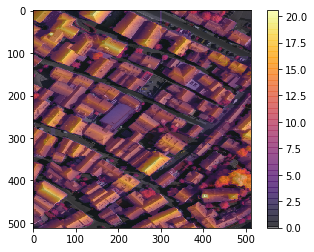

In [15]:
ind = np.random.randint(0,len(imgs_array))

plt.imshow(imgs_array[ind], cmap='gray')
plt.imshow(dsm_tophat[ind], cmap='inferno', alpha=0.5)
plt.colorbar();

Well, ok.  Looks pretty decent on the data side.  It's even sorted consistently!  Let's see what we have for labels; note that there's a bit of logic under the hood that turns the rgb image into onehot encoded images.

In [16]:
labels = loader.load_list('ISPRS/gt', 'top_mosaic_09cm_area')
labels = sorted(labels)

In [17]:
label_array = loader.load_and_resize_rgb_labels(labels, 512, 3)

In [18]:
label_array.shape

(33, 512, 512, 6)

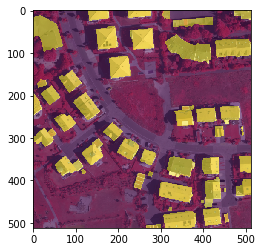

In [19]:
ind = np.random.randint(0,len(imgs_array))

plt.imshow(imgs_array[ind])
plt.imshow(label_array[ind,:,:,1], alpha=0.5)

The normalized difference vegetation index is a common measurement used in remote sensing.  Apparently it's just a rate of change in the color dimensions?

In [20]:
norm_veggies = preproc.ndvi(imgs_array)

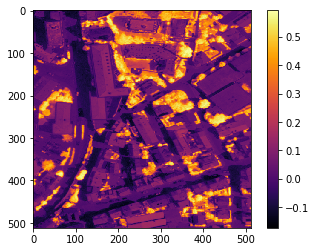

In [21]:
plt.imshow(norm_veggies[0], cmap='inferno')
plt.colorbar();

Let's save our arrays to disk.  I have created a sub folder called "data_arrays" to hold our numerous image arrays.

In [22]:
np.save('data_arrays/img_array', imgs_array)

In [23]:
np.save('data_arrays/dsm_array', dsm_array)

In [24]:
np.save('data_arrays/veggie_array', norm_veggies)